In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_component_input=2, num_component_output=2):
        super(NeuralNetwork, self).__init__()
        self.num_component_input = num_component_input
        self.num_component_output = num_component_output
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(6, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48,6)
        )

    def forward(self, x):
        output = self.network(x)
        pi = output[:, 0:self.num_component_output]
        mu = output[:, self.num_component_output:2*self.num_component_output]
        sigma = output[:, 2*self.num_component_output:3*self.num_component_output]

        pi = torch.softmax(pi, dim=1)
        sigma = torch.exp(sigma)
        mu = torch.exp(mu)

        return mu, pi, sigma



In [3]:
def loss_function(old_pi, old_mu, old_sigma, new_pi, new_mu, new_sigma, n_samples):

    # Generate samples from the old gaussian mixture
    mix = torch.distributions.Categorical(old_pi)
    comp = torch.distributions.Normal(old_mu, old_sigma)
    gmm = torch.distributions.MixtureSameFamily(mix, comp)

    j = 0
    while j < n_samples:
        new_sample = gmm.sample()
        if new_sample >= 0:
            if(j == 0):
                y = torch.tensor([new_sample]).reshape(1)
            else:
                y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
            j += 1
    
    y_poisson = torch.distributions.Poisson(y).sample((y.shape[0],))

    #Generate the new gaussian mixture
    mix_new = torch.distributions.Categorical(new_pi)
    comp_new = torch.distributions.Normal(new_mu, new_sigma)
    gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
    # Calculate the log likelihood of the new gaussian mixture with the old samples
    log_likelihood = 0
    for i in range(len(y_poisson)):
        #log_likelihood += torch.log(torch.sum(gmm_new.log_prob(y_poisson[i]).exp()))
        log_likelihood += torch.logsumexp(gmm_new.log_prob(y_poisson[i]), dim=0)
    return -log_likelihood


In [12]:
# Define the number of samples in the dataset
num_samples = 10

'''
# Generate random values for each component of the vectors
p1 = np.linspace(0, 1, 10).round(2)
mu1 = np.linspace(0, 10, 10).round(2)
mu2 = np.linspace(0, 10, 10).round(2)
sigma1 = np.linspace(0.01, 5, 10).round(2)
sigma2 = np.linspace(0.01, 5, 10).round(2)

# Create the dataset with all the possible permutations of the components
dataset = torch.tensor([0, 1, 0, 0, 0.01, 0.01]).type(torch.float32)
'''
from scipy.stats import qmc

l_bound_pi = [0]
u_bound_pi = [1]
l_bound_mu = [0]
u_bound_mu = [2]
l_bound_sigma = [0.01]
u_bound_sigma = [1]

sampler = qmc.LatinHypercube(d=1)

p1 = sampler.random(n=10)
mu1 = sampler.random(n=10)
mu2 = sampler.random(n=10)
sigma1 = sampler.random(n=10)
sigma2 = sampler.random(n=10)

p1 = qmc.scale(p1, l_bound_pi, u_bound_pi)
mu1 = qmc.scale(mu1, l_bound_mu, u_bound_mu)
mu2 = qmc.scale(mu2, l_bound_mu, u_bound_mu)
sigma1 = qmc.scale(sigma1, l_bound_sigma, u_bound_sigma)
sigma2 = qmc.scale(sigma2, l_bound_sigma, u_bound_sigma)


for i in range(len(p1)):
    for j in range(len(mu1)):
        for k in range(len(mu2)):
            for l in range(len(sigma1)):
                for m in range(len(sigma2)):
                    if(i == 0 and j == 0 and k == 0 and l == 0 and m == 0):
                        dataset = torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float32).flatten()
                    else:
                        dataset = torch.vstack((dataset,torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float32).flatten()))

#dataset = torch.tensor(dataset)
print(len(dataset))
# split the dataset into training and test shuffling the dataset
dataset=dataset[torch.randperm(dataset.size()[0])]


100000


In [13]:
def train_loop(training_data, model, loss_fn, optimizer):
    model.train()
    counter = 0
    for gaussian_mix_old in training_data:
        # Compute prediction and loss
        
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        mu_new, pi_new, sigma_new = model(gaussian_mix_old.reshape(1,6))
    
        loss = loss_fn(old_pi, old_mu, old_sigma, pi_new, mu_new, sigma_new, 10)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 10000 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1


def test_loop(test_data, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for gaussian_mix_old in test_data:
            old_pi = gaussian_mix_old[0:2]
            old_mu = gaussian_mix_old[2:4]
            old_sigma = gaussian_mix_old[4:6]
            mu_new, pi_new, sigma_new = model(torch.tensor(gaussian_mix_old))

            # Generate samples from the old gaussian mixture
            # A stream of indices from which to choose the component
            mixture_idx = np.random.choice(len(old_pi), size=10, replace=True, p=old_pi)
            # y is the mixture sample
            y = np.fromiter((ss.norm.rvs(old_mu[i], old_sigma[i]) for i in mixture_idx),
                        dtype=np.float64)
            y_poisson = np.fromiter((ss.poisson.rvs(y[i]) for i in y),
                   dtype=np.float64)
    
            test_loss += loss_fn(old_pi, old_mu, old_sigma, pi_new, mu_new, sigma_new, y_poisson)


            test_loss /= len(test_data)
            print(f"Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 5
model = NeuralNetwork(num_component_input=2, num_component_output=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataset, model, loss_function, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 34.909679
loss: 3.704840
loss: -1.458590
loss: -0.929363
loss: 1.658993
loss: -0.931202
loss: -8.842523
loss: 10.382759
loss: -5.155351
loss: -1.389900
Epoch 2
-------------------------------
loss: 1.708147
loss: -0.473177
loss: -4.109357
loss: -0.508894
loss: 1.268651
loss: 1.581941
loss: -5.338694
loss: 5.570471
loss: -5.421062
loss: -3.381277
Epoch 3
-------------------------------
loss: -0.010734
loss: -1.508446
loss: -5.118939
loss: -0.571004
loss: 7.162217
loss: -2.232449
loss: -8.734086
loss: 3.058240
loss: -4.099992
loss: -5.017231
Epoch 4
-------------------------------
loss: 3.134861
loss: -2.832657
loss: -1.295374
loss: -0.763942
loss: 1.080817
loss: 6.463945
loss: -5.090220
loss: 3.000602
loss: -5.527108
loss: -4.010235
Epoch 5
-------------------------------
loss: 2.157034
loss: -3.045451
loss: -4.562458
loss: -0.689327
loss: 11.434970
loss: 2.632011
loss: -4.757775
loss: 4.783462
loss: -5.455184
loss: -7.023130
Done!


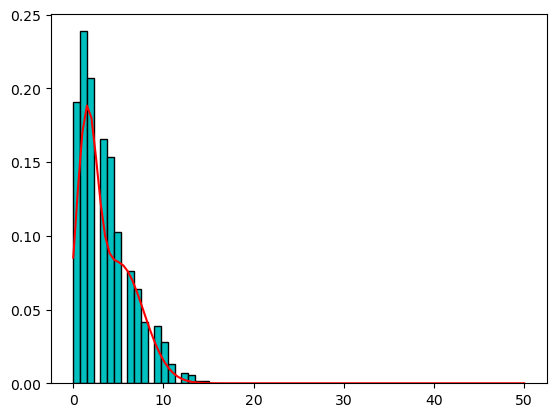

In [65]:
#Check with some distributions
pi = torch.tensor([0.5, 0.5]).type(torch.float32)
mu = torch.tensor([1.1, 4.3]).type(torch.float32)
sigma = torch.tensor([1.5, 2.3]).type(torch.float32)
mix = torch.distributions.Categorical(pi)
comp = torch.distributions.Normal(mu, sigma)
gmm = torch.distributions.MixtureSameFamily(mix, comp)

j = 0
while j < 1000:
    new_sample = gmm.sample()
    if new_sample >= 0:
        if(j == 0):
            y = torch.tensor([new_sample]).reshape(1)
        else:
            y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
        j += 1

y_poisson = torch.distributions.Poisson(y).sample()
y_poisson_np = y_poisson.numpy()
plt.hist(y_poisson_np, bins=20, color='c', edgecolor='black', density=True)

mu_new, pi_new, sigma_new = model(torch.cat((pi,mu,sigma), dim=0).reshape(1,6))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 50, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 50, 100)).reshape(100,1)).exp().detach().numpy(), color='r')

In [17]:
torch.save(model, 'model1.pth')

In [14]:
training_data = dataset[:int(0.9*len(dataset))]

In [15]:
def loss_function_minibatch(gaussian_mixtures, new_pi, new_mu, new_sigma, n_samples):
    count = 0
    total_loss = 0
    for gaussian_mix_old in gaussian_mixtures:
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        
        # Generate samples from the old gaussian mixture
        mix = torch.distributions.Categorical(old_pi)
        comp = torch.distributions.Normal(old_mu, old_sigma)
        gmm = torch.distributions.MixtureSameFamily(mix, comp)

        j = 0
        while j < n_samples:
            new_sample = gmm.sample()
            if new_sample >= 0:
                if(j == 0):
                    y = torch.tensor([new_sample]).reshape(1)
                else:
                    y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
                j += 1
        
        y_poisson = torch.distributions.Poisson(y).sample()

        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(y_poisson))
        total_loss -= log_likelihood
        count += 1
    return total_loss/count


In [16]:
def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):
    model.train()
    counter = 0
    
    for bach_idx, gaussian_mixtures in enumerate(training_dataloader):
        
        mu_new, pi_new, sigma_new = model(gaussian_mixtures)
        loss = loss_fn(gaussian_mixtures, pi_new, mu_new, sigma_new, 50)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1

In [18]:
epochs = 5
#model = NeuralNetwork(num_component_input=2, num_component_output=2)
model = torch.load('model2.pth')
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
train_dataloader = DataLoader(training_data, batch_size=64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch(train_dataloader, model, loss_function_minibatch, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 86.688095
loss: 73.653435
loss: 76.684425
loss: 75.246864
loss: 74.822617
loss: 74.959267
loss: 73.474289
loss: 70.976250
loss: 73.264587
loss: 72.138680
loss: 70.908936
loss: 74.632378
loss: 72.699829
loss: 71.676834
loss: 70.427162
Epoch 2
-------------------------------
loss: 73.048752
loss: 68.468842
loss: 74.467461
loss: 75.377365
loss: 72.375229
loss: 74.073860
loss: 73.612091
loss: 71.070633
loss: 72.225441
loss: 71.430290
loss: 69.886276
loss: 71.310753
loss: 71.086456
loss: 73.987915
loss: 71.124359
Epoch 3
-------------------------------
loss: 72.432976
loss: 68.087044
loss: 72.841751
loss: 72.717651
loss: 71.557770
loss: 71.946159
loss: 72.771492
loss: 70.088356
loss: 73.630234
loss: 70.015457
loss: 71.498039
loss: 72.446930
loss: 72.555710
loss: 71.622734
loss: 69.791710
Epoch 4
-------------------------------
loss: 72.622780
loss: 67.322945
loss: 71.680008
loss: 72.969765
loss: 72.373833
loss: 71.907661
loss: 72.459602
loss: 70

(0.0, 1.0)

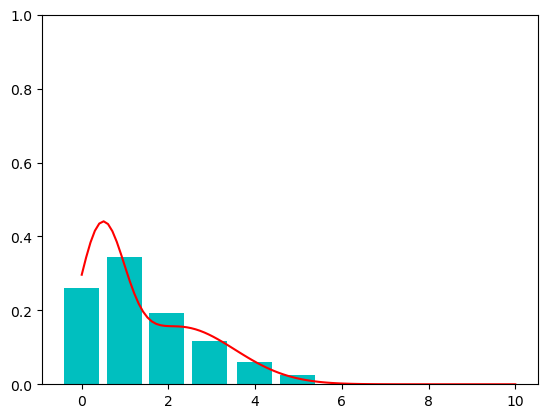

In [54]:
#Check with some distributions
pi = torch.tensor([0.5, 0.7]).type(torch.float32)
mu = torch.tensor([0.95, 1.73]).type(torch.float32)
sigma = torch.tensor([0.05, 0.64]).type(torch.float32)
mix = torch.distributions.Categorical(pi)
comp = torch.distributions.Normal(mu, sigma)
gmm = torch.distributions.MixtureSameFamily(mix, comp)

j = 0
while j < 1000:
    new_sample = gmm.sample()
    if new_sample >= 0:
        if(j == 0):
            y = torch.tensor([new_sample]).reshape(1)
        else:
            y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
        j += 1

y_poisson = torch.distributions.Poisson(y).sample()
y_poisson_np = y_poisson.numpy()
#plt.hist(y_poisson_np, bins=100, density=True)
hist = np.histogram(y_poisson_np, bins=100, density=True)
plt.bar(hist[1][:-1], hist[0]/np.sum(hist[0]), color='c')

mu_new, pi_new, sigma_new = model(torch.cat((pi,mu,sigma), dim=0).reshape(1,6))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 10, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 10, 100)).reshape(100,1)).exp().detach().numpy(), color='r')
plt.ylim(0, 1)

In [66]:
torch.save(model, 'model2.pth')